In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib widget
import pickle
import matplotlib.gridspec as gridspec

from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, leaves_list, dendrogram, fcluster
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, IntSlider
import sys
import glob
sys.path.append("/Users/friederikebuck/Desktop/MBL/project/WholeBrainImagingAnalysis/collab/")
sys.path.append('/Users/bennetsakelaris/Documents/Obsidian Vault/Worms/wormcode/Code+Notes 09-24-24/collab/')

from scipy.ndimage import gaussian_filter1d
from get_data.read_neuro_beh_data import get_exp_features
from get_data.process_neural_data import get_derivative_of_neural_activity, get_neural_activity_from_labels, get_neural_activity_and_labels
from beh_classification.behavior_features import get_behavior_features
from beh_classification.get_behavior_classifications import get_behavior_classification
from beh_classification.beh_classification_utils import get_start_end_is_of_ones_in_binary_array
import socket
import sklearn
from sklearn.cross_decomposition import CCA
from sklearn.utils import shuffle
import os
import copy


def smooth_trace(raw_trace, sigma = 2):
    denoised_data = gaussian_filter1d(raw_trace, sigma=sigma)
    return denoised_data

def shift_array_by_one(array):
    _, n_dim = array.shape
    tmp = np.ones((T, n_dim))*np.nan
    tmp[1:] = array
    array = tmp
    return array


def load_all_data(combine_classes = False):
    combine_classes = np.mod(1+int(combine_classes),2)
    # this just returns lists of traces, neural labels, and behavior for each worm
    # Also includes dtrace
    # be warned that all elements of the list have different shapes
    host = socket.gethostname()[0:6]
    if host == 'Bennet' or host == 'bennet' or 'northwestern' in socket.gethostname():
        json_dir = "/Users/bennetsakelaris/Documents/Obsidian Vault/worms/wormcode/data/Neuropal_no_heat/"
        h5_dir = "/Users/bennetsakelaris/Documents/Obsidian Vault/worms/wormcode/data/processed_h5/"
        beh_data_dir_parent = "/Users/bennetsakelaris/Desktop/behavior/outputs_sparse/"
    else:
        json_dir = "/Users/friederikebuck/Desktop/MBL/project/data/Neuropal_no_heat/"
        h5_dir ="/Users/friederikebuck/Desktop/MBL/project/data/processed_h5/"
        beh_data_dir_parent = "/Users/friederikebuck/Desktop/MBL/project/outputs/"


    directories = glob.glob(json_dir+"*.json") #get filename/paths of all the json files
    exp_dates = [directory.split("/")[-1].split(".")[0] for directory in directories] #extract the exp_dates
    for i in range(len(exp_dates)):
        print("Worm {}, date: {}".format(i, exp_dates[i]))

    full_traces = []
    full_neural_labels = []
    full_beh_classification = []
    full_beh_data = []

    for exp_date in exp_dates:
        dt, T, beh_data, neural_data, neuroID_to_key = get_exp_features(exp_date, 
                                                                    json_dir = json_dir, 
                                                                    h5_dir = h5_dir)
        behavior_features = get_behavior_features(beh_data)
        beh_data.update(behavior_features)
        behavior_classification = get_behavior_classification(beh_data)

        beh_data_dir = os.path.join(beh_data_dir_parent, str(exp_date), "csvs1")
        csv_name = os.path.join(beh_data_dir, "beh_confocal.csv")
        
        

        beh_confocal = np.loadtxt(csv_name, delimiter=",")
        z_beh = beh_confocal
        
        behavior_classification = {
        "is_fwd": beh_confocal==0, 
        "is_rev": beh_confocal==1, 
        "is_turn": beh_confocal==2, 
        "is_pause":  beh_confocal==3,
        }

        neural_labels_orig, ftrace = get_neural_activity_and_labels(neural_data,  denoised = True)

        dtrace = get_derivative_of_neural_activity(smooth_trace(ftrace.T,sigma=5).T, dframes = 1)
        dtrace -= np.mean(dtrace,axis=0)
        dtrace /= np.std(dtrace,axis=0)
        traces = np.concatenate([ftrace[1:,: ],dtrace ], axis =1)
        neural_labels = np.array(["F - "+ lbl[combine_classes] for lbl in neural_labels_orig]+
                                ["dF - "+ lbl[combine_classes] for lbl in neural_labels_orig])
        
        full_traces.append(traces)
        full_neural_labels.append(neural_labels)
        full_beh_classification.append(behavior_classification)
        full_beh_data.append(beh_data)

    return full_traces, full_neural_labels, full_beh_classification, full_beh_data
        


def load_all_data_but_pretend_its_all_one_worm(combine_classes = False):
    # This function concatenates everything into one worm and also returns a mask that tells you which neurons are and arent present
    # Thing to ponder: adding columns of NaNs between worms would probably help the rSLDS learn better
    full_traces, full_neural_labels, full_beh_classification, full_beh_data = load_all_data(combine_classes)

    #get list of all neurons recorded in at least one trial
    neural_labels_set = set()
    for nl in full_neural_labels:
        neural_labels_set = neural_labels_set.union(set(nl))
    neural_labels = np.sort(list(neural_labels_set))

    #now make the traces array, where the different recordings are concatenated and matched by neuron
    #note: a couple of worms have 15 extra timesteps. I am truncating those to make things easier down the line
    T = 1599
    traces = np.zeros((T*len(full_traces), neural_labels.shape[0]))*np.nan #initialize traces to nan 
    #build the traces matrix
    w=0
    for tr, labels, in zip(full_traces, full_neural_labels): #for each worm, w
        for i in range(tr.shape[1]): #for each neuron, i
            label = labels[i] #get neuron name
            idx = np.where(neural_labels==label)[0][0] #get index in full array
            traces[w*T:(w+1)*T, idx] = tr[0:T,i] #put the neuron's activity in the appropriate spot
        w+=1 #update worm index

    

    #set up behavior classification dict
    behavior_classification = dict()
    behavior_classification["is_turn"] = np.zeros(T*len(full_traces))
    behavior_classification["is_pause"] = np.zeros(T*len(full_traces))
    behavior_classification["is_rev"] = np.zeros(T*len(full_traces))
    behavior_classification["is_fwd"] = np.zeros(T*len(full_traces))
    behavior_classification["is_revturn"] = np.zeros(T*len(full_traces))
    behavior_classification["is_purerev"] = np.zeros(T*len(full_traces))
    behavior_classification["is_pureturn"] = np.zeros(T*len(full_traces))
    behavior_classification["is_rev_of_rev_turn"] = np.zeros(T*len(full_traces))
    behavior_classification["is_turn_of_rev_turn"] = np.zeros(T*len(full_traces))

    #fill it in
    w=0
    for bc in full_beh_classification:
        for key in bc.keys():
            behavior_classification[key][w*T:(w+1)*T] = bc[key][1:(T+1)] # shifting by one bc of the trace
        w+=1 #update worm index

    #return mask of nan data
    mask =  (~np.isnan(traces)).astype(int)
    return traces, neural_labels, behavior_classification, mask

# removes neurons that were only recorded in fewer than [threshold] experiments
def remove_rare_neurons(traces, neural_labels, mask, threshold=10): 
    n_occurances = np.zeros(traces.shape[1]) #count the number of occurances for each neuron
    for n in np.arange(0, traces.shape[1]):
        n_occurances[n] = sum(~np.isnan(traces[np.arange(100, traces.shape[0], 1599),n]))
    print("Removing {} neurons that are not recorded in more than {} experiments".format(sum(n_occurances<=threshold)/2, threshold))
    print("{} neurons remaining".format(sum(n_occurances>threshold)/2))
    
    traces = traces[:, n_occurances>threshold]
    neural_labels = neural_labels[n_occurances>threshold]
    mask = mask[:, n_occurances>threshold]
    return traces, neural_labels, mask

def keep_from_list(traces, neural_labels, mask, to_keep):
    n_occurances = np.zeros(traces.shape[1], dtype=bool) #see if each neuron is in to_keep
    for n in np.arange(0, traces.shape[1]):
        n_occurances[n] = neural_labels[n] in to_keep
        print(n_occurances[n])

    print("Removing {} neurons".format((traces.shape[1]-sum(n_occurances))/2))
    print("{} neurons remaining".format(len(to_keep)/2))
    
    traces = traces[:, n_occurances]
    neural_labels = neural_labels[n_occurances]
    mask = mask[:, n_occurances]
    return traces, neural_labels, mask



from matplotlib.colors import LinearSegmentedColormap

#color palette for plotting, colors as in make_behavior_ethogram
palette = ["coral",     # forward
           "lightblue", # reverse
           "darkgreen", # turn
           "purple","red", "yellow", "black", "pink", "grey", "cyan"]    # pause
cmap = LinearSegmentedColormap.from_list("behavior", palette, N=len(palette))

def states_to_changepoints(z):
    assert z.ndim == 1
    z = np.array(z)
    return np.concatenate(([0], 1 + np.where(np.diff(z))[0], [z.size - 1]))

def plot_2d_continuous_states(x, z,
                              colors=palette,
                              ax=None,
                              inds=(0,1),
                              figsize=(2.5, 2.5),
                              **kwargs):

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)

    cps = states_to_changepoints(z)

    # Color denotes our inferred latent discrete state
    for cp_start, cp_stop in zip(cps[:-1], cps[1:]):
        ax.plot(x[cp_start:cp_stop + 1, inds[0]],
                x[cp_start:cp_stop + 1, inds[1]],
                 '-', color=colors[z[cp_start]],
                **kwargs)

def plot_most_likely_dynamics(model,
    xlim=(-4, 4), ylim=(-3, 3), nxpts=20, nypts=20,
    alpha=0.3, ax=None, figsize=(3, 3), color=None):
    
    K = model.K
    assert model.D == 2
    x = np.linspace(*xlim, nxpts)
    y = np.linspace(*ylim, nypts)
    X, Y = np.meshgrid(x, y)
    xy = np.column_stack((X.ravel(), Y.ravel()))

    # Get the probability of each state at each xy location
    try:
        z = np.argmax(xy.dot(model.transitions.Rs.T) + model.transitions.r, axis=1)
    except:
        z = np.argmax(xy.dot(model.transitions.Rs.T), axis=1)

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)

    for k, (A, b) in enumerate(zip(model.dynamics.As, model.dynamics.bs)):
        dxydt_m = xy.dot(A.T) + b - xy

        zk = z == k
        if zk.sum(0) > 0:
            if color == None:
                ax.quiver(xy[zk, 0], xy[zk, 1],
                        dxydt_m[zk, 0], dxydt_m[zk, 1],
                        color=palette[k % len(palette)], alpha=alpha)
            else:
                ax.quiver(xy[zk, 0], xy[zk, 1],
                        dxydt_m[zk, 0], dxydt_m[zk, 1],
                        color=color, alpha=alpha)

    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    plt.tight_layout()

    return ax


def plot_dynamic_landscape(model,k,
    xlim=(-4, 4), ylim=(-3, 3), nxpts=20, nypts=20,
    alpha=0.3, ax=None, figsize=(3, 3), color=None):
    assert model.D == 2
    K = model.K
    x = np.linspace(*xlim, nxpts)
    y = np.linspace(*ylim, nypts)
    X, Y = np.meshgrid(x, y)
    xy = np.column_stack((X.ravel(), Y.ravel()))

    # Get the probability of each state at each xy location
    try:
        z = np.argmax(xy.dot(model.transitions.Rs.T) + model.transitions.r, axis=1)
    except:
        z = np.argmax(xy.dot(model.transitions.Rs.T), axis=1)

    if ax is None:
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    dxydt_m = xy.dot(model.dynamics.As[k].T) + model.dynamics.bs[k] - xy
    dxydt_m_norm = np.zeros((len(dxydt_m)))
    for xt in range(len(dxydt_m_norm)):
        dxydt_m_norm[xt] = np.linalg.norm(dxydt_m[xt,:])

    ax.plot_trisurf(xy[:,0], xy[:,1], dxydt_m_norm, cmap = "coolwarm", linewidth=0, antialiased=False)

    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    plt.tight_layout()

    return ax

def plot_most_likely_dynamics(model, test_x, test_z, pca_x, pc3 = 0, input_str=0, input_id=0, ax=None, lim = None, plot_trajectory=True, inds=(0,1), do_pca=True, velocity=False):
    ind1,ind2 = inds
    pca = PCA(n_components=pca_x.shape[1])
    x_centered = pca_x - np.mean(pca_x, axis=0)
    pca.fit(x_centered)  # X is your trajectory data matrix
    X_pca = pca.transform(test_x - np.mean(pca_x, axis=0) )
    
    K = model.K
    # Define grid limits based on PCA-transformed trajectory
    if lim == None:
        x_min, x_max = X_pca[:, ind1].min() - 3, X_pca[:, ind1].max() + 3
        y_min, y_max = X_pca[:, ind2].min() - 3, X_pca[:, ind2].max() + 3
        lim = [x_min, x_max, y_min, y_max]
    else:
        x_min = lim[0]
        x_max = lim[1]
        y_min = lim[2]
        y_max = lim[3]

    # Create a grid of points
    x = np.linspace(x_min, x_max, 30)  # 30 grid points along x-axis
    y = np.linspace(y_min, y_max, 30)  # 30 grid points along y-axis
    X_grid, Y_grid = np.meshgrid(x, y)  # Create the grid

    # Inverse transform to get high-dimensional coordinates of grid points
    xy = np.column_stack(pca_x.shape[1]*[0*Y_grid.ravel()])
    xy[:,ind1] = X_grid.ravel()
    xy[:,ind2] = Y_grid.ravel()

    if do_pca:
        xy_high_dim = pca.inverse_transform(xy)  # Map back to original space
    else:
        xy_high_dim = xy

    # Get the probability of each state at each xy location
    try:
        z = np.argmax(xy_high_dim.dot(model.transitions.Rs.T) + model.transitions.r, axis=1)
    except:
        z = np.argmax(xy_high_dim.dot(model.transitions.Rs.T), axis=1)

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    velocity_magnitudes = np.zeros_like(X_grid.ravel())

    if model.M == 0:
        for k, (A, b) in enumerate(zip(model.dynamics.As, model.dynamics.bs)):
            next_step_high_dim = xy_high_dim @ A.T + b  # x_t+1 = Ax_t + b
            # Map back to PCA space for visualization
            if do_pca:
                next_step_pca = next_step_high_dim @ pca.components_.T
            else:
                next_step_pca = next_step_high_dim

            zk = z == k
            if zk.sum(0) > 0:
                ax.quiver(xy[zk, ind1], xy[zk, ind2],
                        next_step_pca[zk, ind1]-xy[zk,ind1], next_step_pca[zk, ind2]-xy[zk,ind2],
                        color=palette[k % len(palette)], alpha=1)
            velocity_magnitudes[zk] = np.linalg.norm(next_step_pca[zk] - xy[zk], axis=1)
    else:
        for k, (A, b, V) in enumerate(zip(model.dynamics.As, model.dynamics.bs, model.dynamics.Vs)):
            next_step_high_dim = xy_high_dim @ A.T + b + input_str*V[:,input_id] # x_t+1 = Ax_t + b
            # Map back to PCA space for visualization
            if do_pca:
                next_step_pca = next_step_high_dim @ pca.components_.T
            else:
                next_step_pca = next_step_high_dim

            zk = z == k
            if zk.sum(0) > 0:
                ax.quiver(xy[zk, ind1], xy[zk, ind2],
                        next_step_pca[zk, ind1]-xy[zk,ind1], next_step_pca[zk, ind2]-xy[zk,ind2],
                        color=palette[k % len(palette)], alpha=1)
                velocity_magnitudes[zk] = np.linalg.norm(next_step_pca[zk] - xy[zk], axis=1)
            
    if velocity:
        ax.cla()
         # Reshape velocity magnitudes to match grid
        velocity_magnitudes = velocity_magnitudes.reshape(30, 30)

        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 6))

        # Plot the velocity heatmap
        heatmap = ax.pcolormesh(X_grid, Y_grid, velocity_magnitudes, cmap="Purples", shading='auto')
        plt.colorbar(heatmap, ax=ax, label="Velocity Magnitude")
                
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    plt.tight_layout()
    if plot_trajectory:
        if do_pca:
            plot_2d_continuous_states(X_pca, test_z, ax=ax, inds=inds)
        else:
            plot_2d_continuous_states(test_x, test_z, ax=ax, inds=inds)
    ax.set_xlim(x_min+2, x_max-2)
    ax.set_ylim(y_min+2, y_max-2)

    return ax, lim

def input_slds(slds, input_list_dynamics, input_list_emissions=[]):
    new_slds = copy.deepcopy(slds)

    new_slds.M += len(input_list_dynamics) + len(input_list_emissions)
    new_slds.emissions.M = new_slds.M
    new_slds.dynamics.M = new_slds.M
    new_slds.transitions.M = new_slds.M

    # Inititalize new input-driven properties
    Vs = np.zeros((new_slds.K, new_slds.D, new_slds.M))
    Fs = np.zeros((1, new_slds.N, new_slds.M))
    Ws = np.zeros((new_slds.K, new_slds.M))

    if slds.M > 0: #if old slds already supported inputs
        Vs[:,:,:slds.M] = slds.dynamics.Vs
        Ws[:,:slds.M] = slds.transitions.Ws
        Fs[:,:,:slds.M] = slds.emissions.Fs

    # Here I'm only changing Vs but maybe its worth changing Ws at some point
    input_dict = {} # neuron name -> input index
    for i in range(len(input_list_dynamics)):
        input_dict[input_list_dynamics[i]] = slds.M+i
        idx = np.argwhere(neural_labels == f"dF - {input_list_dynamics[i]}")[0][0]
        latent_vec = new_slds.emissions.Cs[0][idx]
        for k in range(new_slds.K):
            Vs[k, :,slds.M+i] = latent_vec

    for i in range(len(input_list_emissions)):
        input_dict["e"+input_list_emissions[i]] = slds.M + i + len(input_list_dynamics)
   
        idx = np.argwhere(neural_labels == f"dF - {input_list_emissions[i]}")[0][0]
        Fs[0,idx,slds.M+i+ len(input_list_dynamics)] = 10
        idx = np.argwhere(neural_labels == f"F - {input_list_emissions[i]}")[0][0]
        Fs[0,idx,slds.M+i+ len(input_list_dynamics)] = 10
                
    new_slds.dynamics.Vs = Vs
    new_slds.transitions.Ws = Ws
    new_slds.emissions.Fs = Fs
    return new_slds, input_dict


# Load all worms
Look at shapes

In [2]:
T = 1599
full_traces, full_neural_labels, full_beh_classification, full_beh_data = load_all_data(combine_classes=True)
for i in range(len(full_beh_classification)):
    print("Worm {} number of neurons: {}, timesteps: {}".format(i, full_traces[i].shape[1]/2, full_traces[i].shape[0])) #dividing neurons by 2 to include both traces and dtraces

Worm 0, date: 2022-06-14-01
Worm 1, date: 2023-01-23-08
Worm 2, date: 2022-06-28-07
Worm 3, date: 2022-07-15-12
Worm 4, date: 2023-01-19-01
Worm 5, date: 2022-08-02-01
Worm 6, date: 2022-06-14-07
Worm 7, date: 2022-06-28-01
Worm 8, date: 2023-01-23-15
Worm 9, date: 2022-07-26-01
Worm 10, date: 2023-01-19-15
Worm 11, date: 2023-03-07-01
Worm 12, date: 2022-06-14-13
Worm 13, date: 2023-01-23-21
Worm 14, date: 2023-01-19-22
Worm 15, date: 2023-01-23-01
Worm 16, date: 2023-01-17-01
Worm 17, date: 2022-07-20-01
Worm 18, date: 2023-01-09-28
Worm 19, date: 2023-01-19-08
Worm 20, date: 2022-07-15-06


FileNotFoundError: /Users/bennetsakelaris/Desktop/behavior/outputs_sparse/2022-06-14-01/csvs1/beh_confocal.csv not found.

# Concatenate into one big worm


Worm 0, date: 2022-06-14-01
Worm 1, date: 2023-01-23-08
Worm 2, date: 2022-06-28-07
Worm 3, date: 2022-07-15-12
Worm 4, date: 2023-01-19-01
Worm 5, date: 2022-08-02-01
Worm 6, date: 2022-06-14-07
Worm 7, date: 2022-06-28-01
Worm 8, date: 2023-01-23-15
Worm 9, date: 2022-07-26-01
Worm 10, date: 2023-01-19-15
Worm 11, date: 2023-03-07-01
Worm 12, date: 2022-06-14-13
Worm 13, date: 2023-01-23-21
Worm 14, date: 2023-01-19-22
Worm 15, date: 2023-01-23-01
Worm 16, date: 2023-01-17-01
Worm 17, date: 2022-07-20-01
Worm 18, date: 2023-01-09-28
Worm 19, date: 2023-01-19-08
Worm 20, date: 2022-07-15-06


Text(0, 0.5, '# neurons')

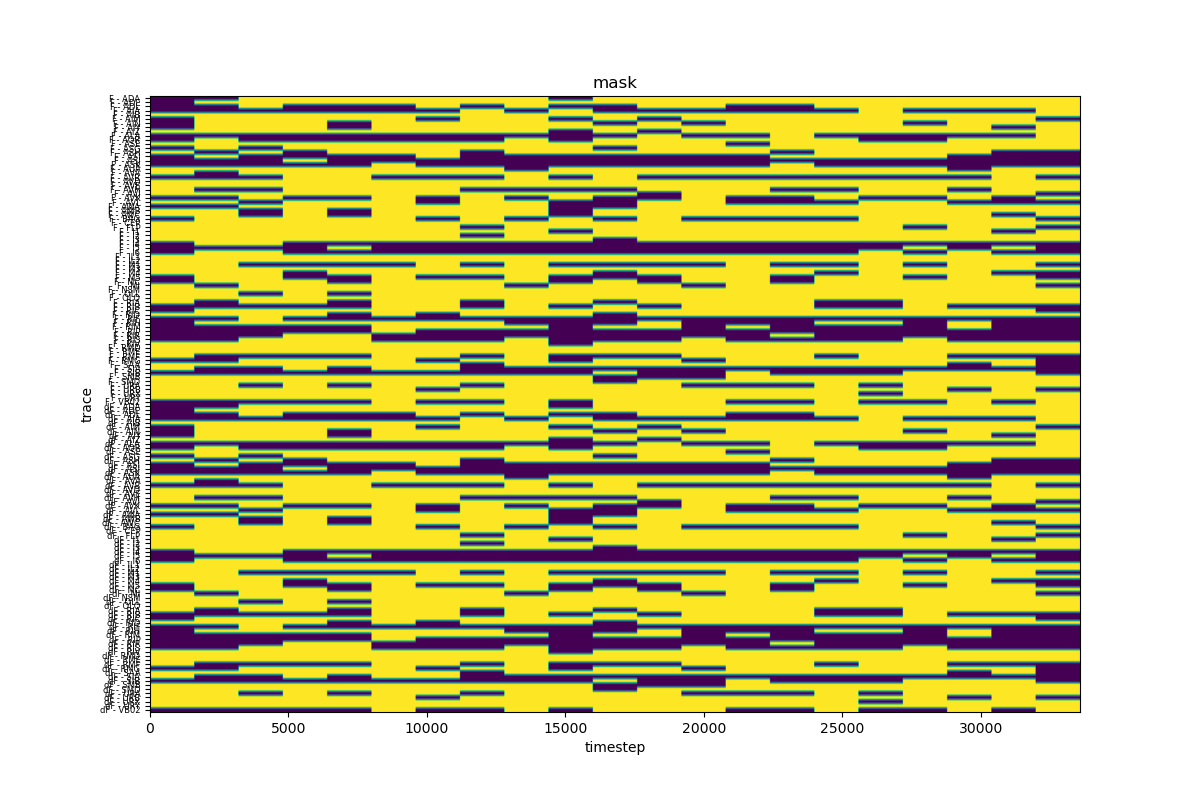

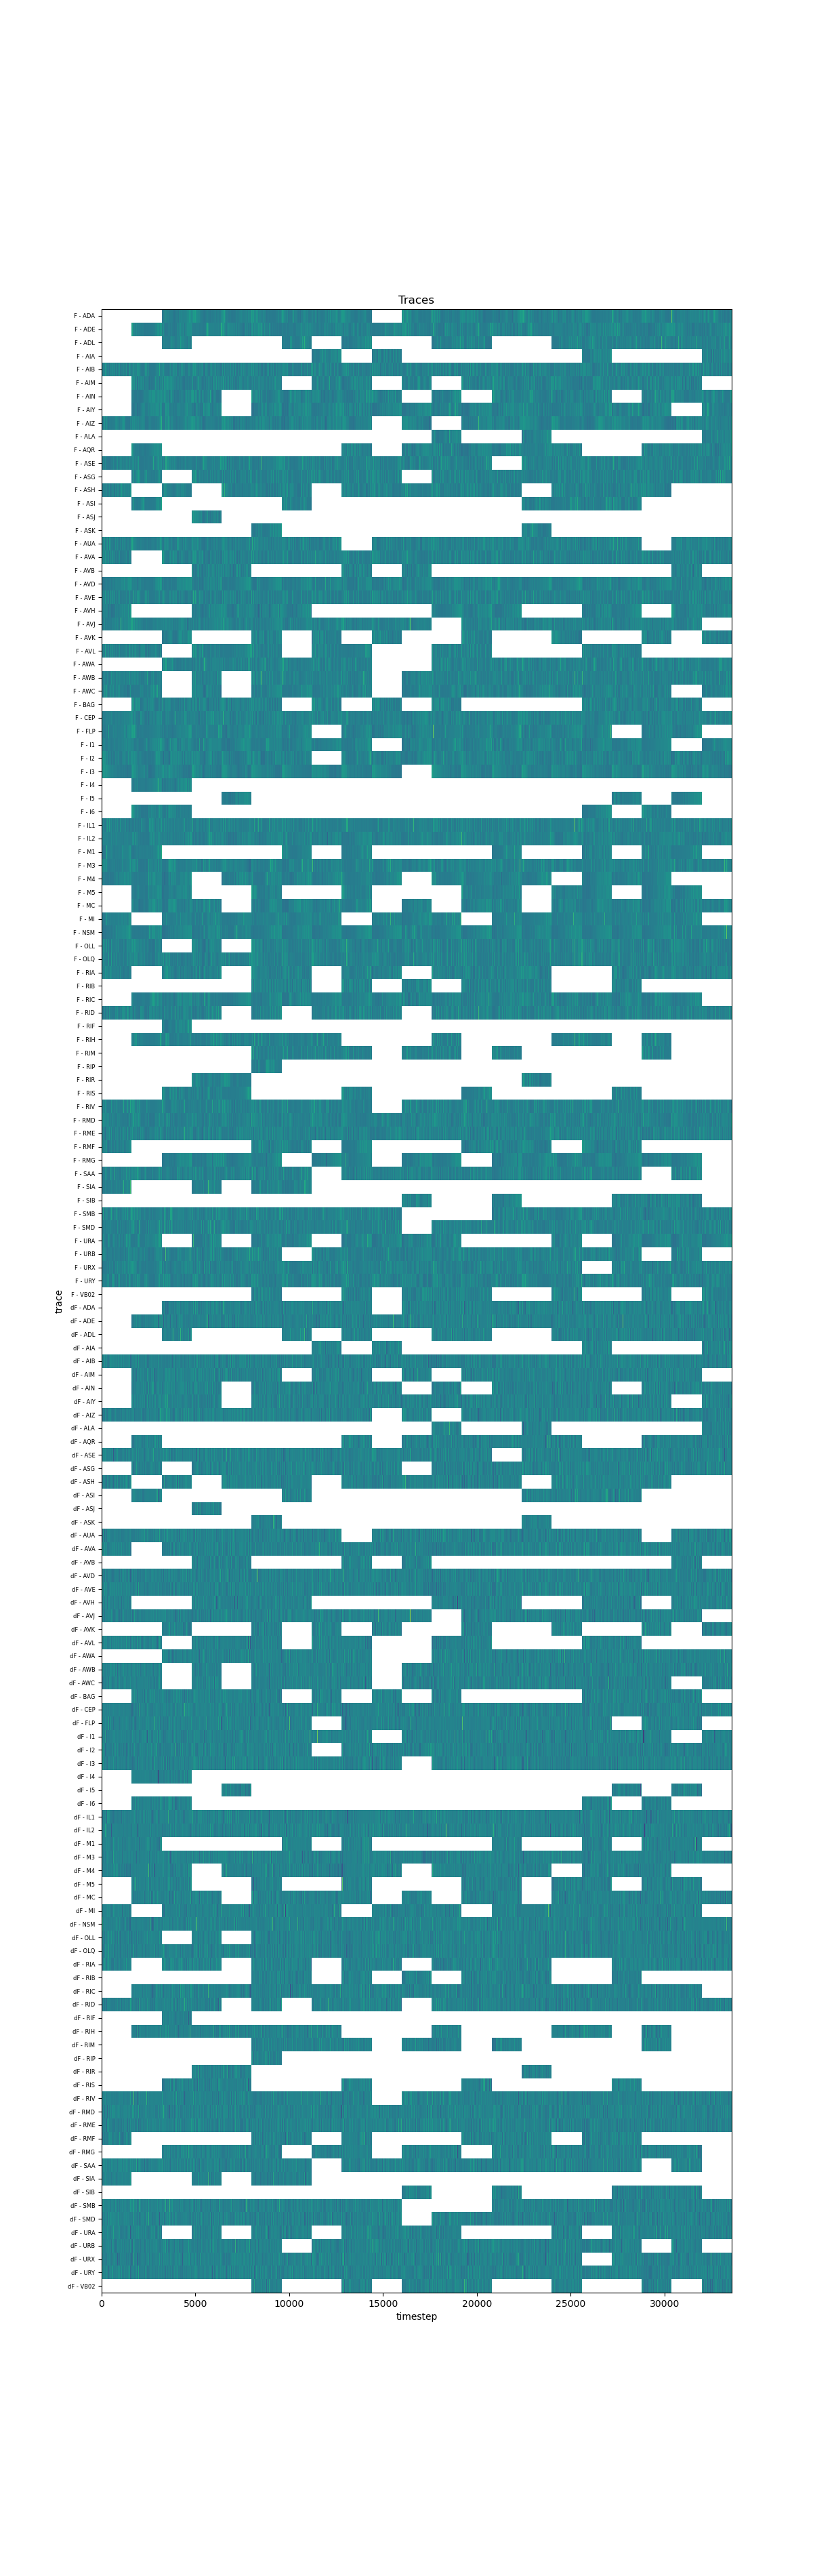

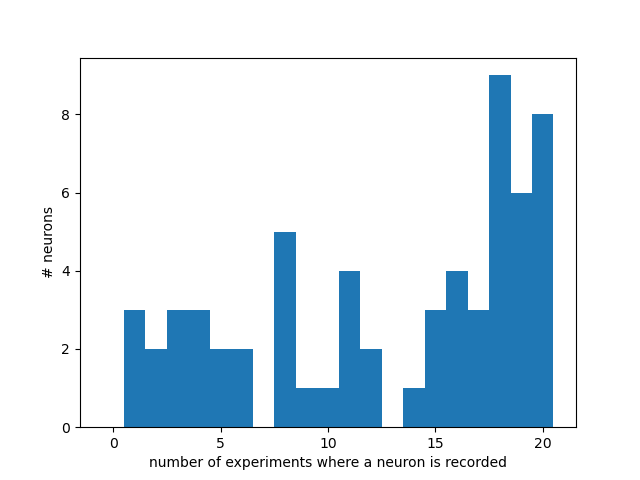

In [ ]:
traces_all, neural_labels_all, behavior_classification, mask_all = load_all_data_but_pretend_its_all_one_worm(combine_classes=True)

fig,ax = plt.subplots(1,1, figsize=(12,8))
ax.imshow(mask_all.T, aspect="auto")
ax.set_xlabel("timestep")
ax.set_ylabel("trace")
ax.set_yticks(np.arange(neural_labels_all.shape[0]), labels=neural_labels_all, fontsize=6)
ax.set_title("mask")


fig,ax = plt.subplots(1,1, figsize=(12,38))

ax.imshow(traces_all.T, aspect="auto", interpolation='none')
ax.set_xlabel("timestep")
ax.set_ylabel("trace")
ax.set_yticks(np.arange(neural_labels_all.shape[0]), labels=neural_labels_all, fontsize=6)
ax.set_title("Traces")


n_occurances = np.zeros(traces_all.shape[1]//2) #count the number of occurances for each neuron
for n in np.arange(0, traces_all.shape[1]//2):
    n_occurances[n] = sum(~np.isnan(traces_all[np.arange(100, traces_all.shape[0], 1599),n]))
fig,ax = plt.subplots(1,1)
ax.hist(n_occurances, np.arange(0,22)-0.5)
ax.set_xlabel("number of experiments where a neuron is recorded")
ax.set_ylabel("# neurons")

# Remove neurons that werent recorded in many of the experiments

Removing 5.0 neurons that are not recorded in more than 2 experiments
69.0 neurons remaining


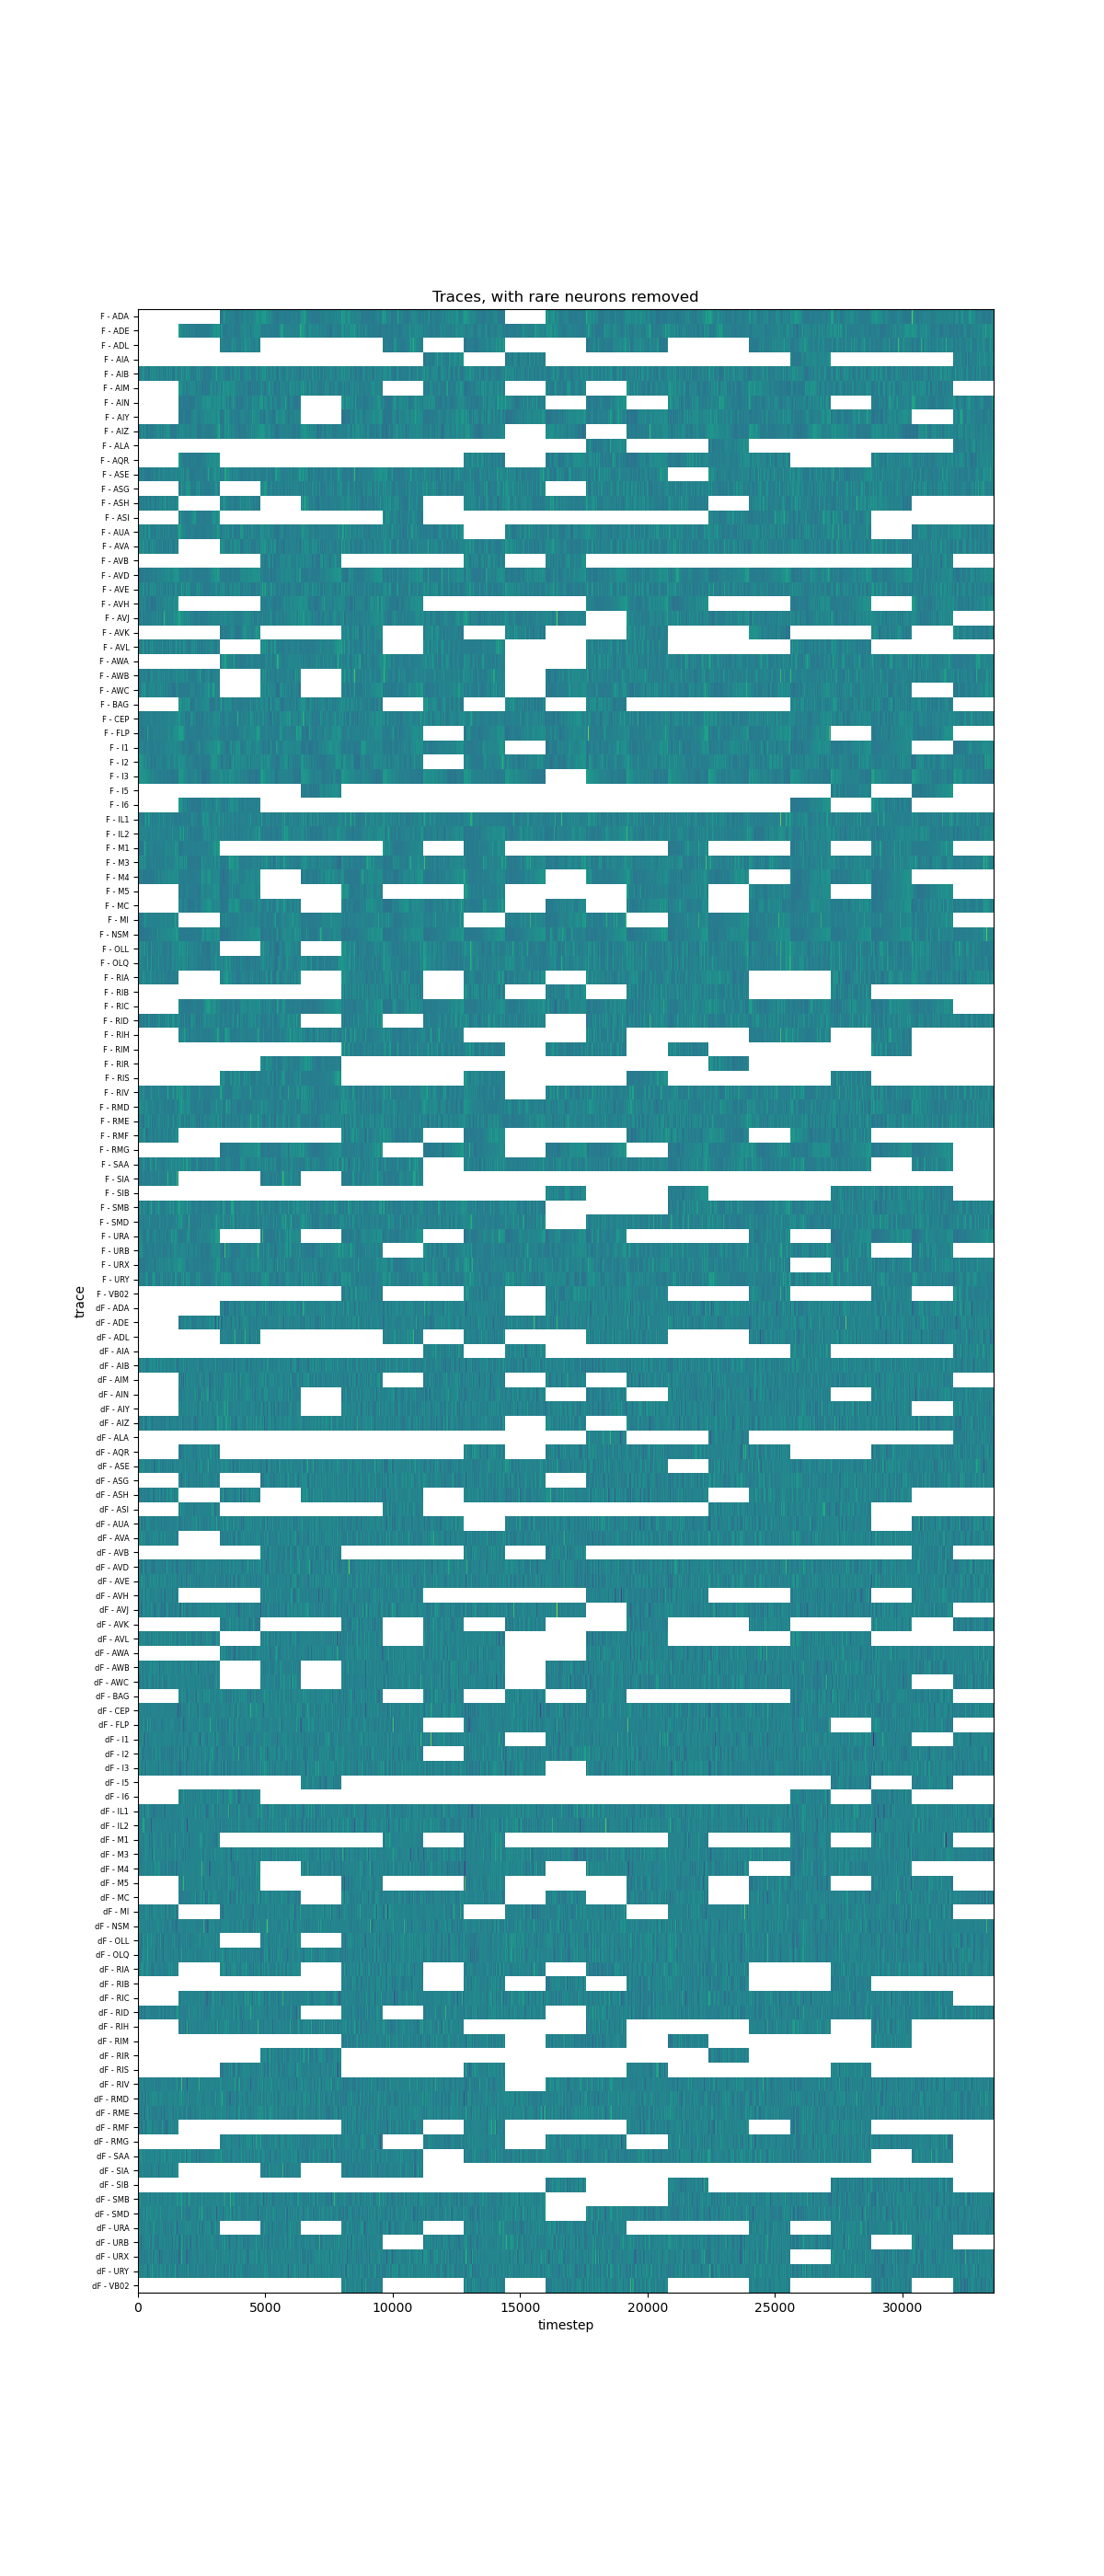

In [ ]:
# neurons_to_keep =  ['F - RIMR','F - URYDR','F - RIH','F - OLQVL','F - RIML','F - ADAL','F - RMDVR','F - OLLL','F - CEPDR','F - SAAD?','F - AVAL','F - ASHR','F - IL1DR','F - URYVL','F - ASHL','F - RIVL','F - ASEL','F - CEPVL','F - IL1L','F - CEPVR','F - AUAL','F - RMER','F - OLQDL','F - AVAR','F - AUAR','F - URXL',
#                     'F - BAGR','F - OLQDR','F - AIBR','F - URYVR','F - OLLR','F - URXR','F - ASGL','F - RMDR','F - RMDL','F - AWBL','F - AVL','F - AWAR','F - AVER','F - AIY?','F - URAVL','F - OLQVR','F - AQR','F - RIAL','F - IL1R','F - AWBR','F - SMDVL','F - I3','F - RMEV','F - ASGR','F - M4','F - AWAL',
#                     'dF - RIMR','dF - URYDR','dF - RIH','dF - OLQVL','dF - RIML','dF - ADAL','dF - RMDVR','dF - OLLL','dF - CEPDR','dF - SAAD?','dF - AVAL','dF - ASHR','dF - IL1DR','dF - URYVL','dF - ASHL','dF - RIVL','dF - ASEL','dF - CEPVL','dF - IL1L','dF - CEPVR','dF - AUAL','dF - RMER','dF - OLQDL','dF - AVAR','dF - AUAR','dF - URXL',
#                     'dF - BAGR','dF - OLQDR','dF - AIBR','dF - URYVR','dF - OLLR','dF - URXR','dF - ASGL','dF - RMDR','dF - RMDL','dF - AWBL','dF - AVL','dF - AWAR','dF - AVER','dF - AIY?','dF - URAVL','dF - OLQVR','dF - AQR','dF - RIAL','dF - IL1R','dF - AWBR','dF - SMDVL','dF - I3','dF - RMEV','dF - ASGR','dF - M4','dF - AWAL']

#traces, neural_labels, mask = keep_from_list(traces_all, neural_labels_all, mask_all, neurons_to_keep)
traces, neural_labels, mask = remove_rare_neurons(traces_all, neural_labels_all, mask_all, threshold=2)
#traces, neural_labels, mask = remove_rare_neurons(traces_all, neural_labels_all, mask_all, threshold=15)
#traces, neural_labels, mask = keep_from_list(traces_all, neural_labels_all, mask_all, neural_labels[:neural_labels.size//2]) # keep only F, no dF
#traces, neural_labels, mask = keep_from_list(traces_all, neural_labels_all, mask_all, neural_labels[neural_labels.size//2+1:]) # keep only dF, no F

# foldername = "for_neural_var/"
# items = np.array(os.listdir(foldername))
# folders = np.array(["." not in directory for directory in items], dtype=bool)
# folders = items[folders]
# folder = folders[0]

# neural_var_explained = np.load(foldername+folder+"/neural_var_explained.npy", allow_pickle=True)
# to_remove = np.nanmean(neural_var_explained.T, axis=0)<0.3
# classes = [neuron.split(' - ')[1] for neuron in neural_labels_all[to_remove] ]
# classes = np.unique(classes)
# Fs = ["F - " + classs for classs in classes]
# dFs = ["dF - " + classs for classs in classes]
# neurons_to_remove = Fs + dFs
# neurons_to_keep = list(set(neural_labels_all) - set(neurons_to_remove))
# #traces, neural_labels, mask = keep_from_list(traces_all, neural_labels_all, mask_all, neurons_to_keep)



# fig,ax = plt.subplots(1,1, figsize=(12,28))
# ax.imshow(traces.T, aspect="auto", interpolation='none')
# ax.set_xlabel("timestep")
# ax.set_ylabel("trace")
# ax.set_yticks(np.arange(neural_labels.shape[0]), labels=neural_labels, fontsize=6)
# ax.set_title("Traces, with rare neurons removed")





## rSLDS time!

Fit

In [ ]:
import ssm
from ssm.util import random_rotation, find_permutation
from ssm.plots import plot_dynamics_2d
from ssm.extensions.mp_srslds.transitions_ext import StickyRecurrentOnlyTransitions
#rSLDS assumptions
transition = "recurrent_only"
#transition = "sticky_recurrent_only"
dynamic = "diagonal_gaussian"
emission = "gaussian_orthog"



np.random.seed(0)


Y = np.copy(traces)
Y[np.isnan(Y)] = 0
Y = [Y[i*1599:1599*(i+1)] for i in range(len(full_traces))] #convert to list where each element is the time series of a different worm
mask=mask.astype(bool)
masks = [mask[i*1599:1599*(i+1)] for i in range(len(full_traces))] #likewise for mask
print(len(Y))
print(Y[5].shape)
tags = [None]*len(masks)
# set up a single behavioral state array ("z" in the language of scott): 
#   0: is_fwd
#   1: is_rev
#   2: is_turn
z = behavior_classification["is_fwd"]+ 2*behavior_classification["is_rev"]+ 4*behavior_classification["is_pause"]+3*behavior_classification["is_turn"]-1
z = z.astype(int)

emissions_dim = neural_labels.shape[0]


def train_global_rslds(n_disc_states, latent_dim, i_want_to_plot_fitting = False):
    # Create the model and initialize its parameters
    slds = ssm.SLDS(emissions_dim, n_disc_states, latent_dim,
                    transitions=transition,
                    dynamics=dynamic, 
                    emissions=emission, dynamics_kwargs=dict(l2_penalty_A=5000),
                    single_subspace=True, verbose=False)


    # Fit the model using Laplace-EM with a structured variational posterior
    q_elbos, q = slds.fit(Y, method="laplace_em", #default
                                variational_posterior="structured_meanfield", #default
                                num_iters=50, alpha=0, masks=masks, tags=tags, num_init_restarts=15, verbose=False)
    
    try:
        slds.permute(find_permutation(z[0:1599], slds.most_likely_states(q.mean_continuous_states[0], Y[0])))
    except:
        pass

    if i_want_to_plot_fitting:
        # plot results of SLDS fitting to make sure it converged
        fig, axs = plt.subplots(1, 1)
        axs.plot(q_elbos)
        axs.set_xlabel("Iteration")
        axs.set_ylabel("ELBO")
        plt.tight_layout()

    return slds, q

21
(1599, 138)


# Hierarchical rSLDS
The gist
* Each worm gets its own rSLDS
* the worm-specific rSLDSs are loosely tied together through a shared prior

How to find shared prior? A couple of options
* iteratively: one fitting step of each rslds -> avg parameters across worms (update prior) -> resample rslds from updated prior -> repeat
* two-stage: completely fit all rslds -> avg parameters across worms (update prior) -> resample rslds from updated prior -> fit again, this time with updated prior -> done
* train a rslds jointly on all data (similar to the iterative approach but without resampling) -- this is what i did in this version bc its much faster and doesnt seem to give very different results from the others
I 


## Initialize worm models

In [ ]:
import scipy, copy
from tqdm import tqdm
import seaborn as sns
from datetime import datetime

def initialize_global_prior(model):
    K = len(model.dynamics.As)  
    latent_dim = model.D  

    # Initialize global prior
    global_prior = {
        "A_mean": np.zeros((K, latent_dim, latent_dim)),
        "b_mean": np.zeros((K, latent_dim)),
        "Q_prior": {"Psi": np.eye(latent_dim), "nu": latent_dim + 2},
        "r_mean": np.zeros(K),
        "R_mean": np.zeros((K, latent_dim))
    }

    # Populate dynamics matrices A and biases b
    global_prior["A_mean"] = np.stack(model.dynamics.As, axis=0)
    global_prior["b_mean"] = np.stack(model.dynamics.bs, axis=0)
    
    # Populate noise covariance prior
    global_prior["Q_prior"]["Psi"] = np.mean(np.stack(model.dynamics.Sigmas, axis=0), axis=0)
    
    # Populate transition parameters
    global_prior["r_mean"] = model.transitions.r
    global_prior["R_mean"] = np.stack(model.transitions.Rs, axis=0)
    
    return global_prior




def update_global_prior(worm_models, global_prior):
    num_worms = len(worm_models)
    K = worm_models[0].K 
    
    # Initialize arrays 
    A_sum = np.zeros((K, worm_models[0].D, worm_models[0].D))
    b_sum = np.zeros((K, worm_models[0].D))
    Q_sum = np.zeros((K, worm_models[0].D, worm_models[0].D))
    r_sum = np.zeros(K)
    R_sum = np.zeros((K, worm_models[0].D))
    

     # Compute mean across worms
    for model in worm_models:
        A_sum += np.stack(model.dynamics.As, axis=0)  
        b_sum += np.stack(model.dynamics.bs, axis=0) 
        Q_sum += np.stack(model.dynamics.Sigmas, axis=0) 
        r_sum += model.transitions.r 
        R_sum += np.stack(model.transitions.Rs, axis=0)  
    
   
    global_prior["A_mean"] = A_sum / num_worms
    global_prior["b_mean"] = b_sum / num_worms
    global_prior["Q_prior"]["Psi"] = np.mean(Q_sum, axis=0)  # Update noise prior Psi

    global_prior["r_mean"] = r_sum / num_worms
    global_prior["R_mean"] = R_sum / num_worms
    
    return global_prior




def resample_parameters(model, global_prior):
    K = model.K

    model.dynamics.As = np.array([
        np.random.multivariate_normal(global_prior["A_mean"][k].flatten(), global_prior["A_cov"]).reshape(model.D, model.D)
        for k in range(K)
    ])
    
    model.dynamics.bs = np.array([
        np.random.multivariate_normal(global_prior["b_mean"][k], global_prior["b_cov"])
        for k in range(K)
    ])

    model.dynamics.Sigmas = np.array([
        scipy.stats.invwishart.rvs(scale=global_prior["Q_prior"]["Psi"], df=global_prior["Q_prior"]["nu"])
        for k in range(K)
    ])

    model.transitions.r = np.random.multivariate_normal(global_prior["r_mean"], global_prior["r_cov"])
    model.transitions.Rs = np.array([
        np.random.multivariate_normal(global_prior["R_mean"][k], global_prior["R_cov"])
        for k in range(K)
    ])

def initialize_worm_models(slds):
    K = slds.K
    latent_dim = slds.D
    # Shared prior
    global_prior = {
        "A_mean": np.zeros((K, latent_dim, latent_dim)),
        "A_cov": np.eye(latent_dim * latent_dim)*0.04,
        "b_mean": np.zeros((K, latent_dim)),
        "b_cov": np.eye(latent_dim)*.13,
        "Q_prior": {"Psi": np.eye(latent_dim), "nu": latent_dim + 2},
        "r_mean": np.zeros(K),
        "r_cov": np.eye(K),
        "R_mean": np.zeros((K, latent_dim)),
        "R_cov": np.eye(latent_dim)*.5,
    }

    # Worm-specific models
    worm_models = []
    for worm_data in Y:
        model = copy.deepcopy(slds)
        worm_models.append(model)
        
    return global_prior, worm_models



def plot_and_save(worm_models, qs, filestr):
    q_z_full = []
    q_x_full = []
    n_disc_states = worm_models[0].K


    for w, model in enumerate(worm_models):
        q = qs[w]
            
        # Get the posterior mean of the continuous states
        q_x = q.mean_continuous_states[0]
        Y_w = Y[w]
        
        z_w = z[w*1599:(w+1)*1599]
        q_z = model.most_likely_states(q_x, Y_w) #this is estimated behavioral state
        q_x_full.append(q_x)

        try:
            model.permute(find_permutation(z_w, q_z))
        except:
            pass
        
        q_z = model.most_likely_states(q_x, Y_w) #this is estimated behavioral state
        q_z_full.append(q_z)

        # Plot state overlap as percent of actual
        overlap = np.zeros((3, n_disc_states))
        denom = []
        for i in range(3):
            denom.append(sum(z_w==i))
        for t in range(len(z_w)):
            overlap[z_w[t],q_z[t]] +=1.0/denom[z_w[t]]
        if True:
            fig, ax = plt.subplots(1,1, figsize=(8,6))
            im = ax.imshow(overlap, vmin=0, vmax=1)
            ax.set_xlabel("estimated")
            ax.set_ylabel("true")
            fig.colorbar(im, ax=ax)
            ax.set_yticks(np.arange(0,3), labels=["forwards", "backwards", "turning"], rotation=0)    
            ax.set_xticks(np.arange(0,n_disc_states))
            ax.set_title("State overlap, worm {}".format(w))
            fig.savefig(filestr+"/saved_figs/"+f"worm{w}_overlap.png")
            plt.close()

            # Plot the true and inferred states
            # fig, axs = plt.subplots(2,1, figsize=(18,6))
            # axs[0].imshow(z_w[None,:], aspect="auto", cmap=cmap, alpha=0.3, vmin=0, vmax=len(palette))
            # axs[1].imshow(q_z[None,:], aspect="auto", cmap=cmap, alpha=0.3, vmin=0, vmax=len(palette))
            # axs[0].set_yticks([]); axs[1].set_yticks([])
            # axs[0].set_title("Given labels"); axs[1].set_title("Inferred by rSLDS")
            # axs[1].set_xticks([])
            


        #phase portraits
        pca = PCA() 
        pca_x = pca.fit_transform(q_x) #do pca
        id1=0 #choose which 2 PCs you want to plot
        id2=1
        W = pca.components_[[id1,id2],:]  # get components


        # Create the PCA-space rslds model and initialize its parameters
        # This is done so we can feed it into to scotts handy plot_most_likely_dynamics function
        pca_slds = ssm.SLDS(emissions_dim, n_disc_states, 2,
                        transitions=transition,
                        dynamics=dynamic,
                        emissions=emission,
                        single_subspace=True)


        #plot the phase portraits in PCA world
        for k in range(n_disc_states):
            # Dimensionality-reduced versions of A and b
            A_reduced = W @ model.dynamics.As[k] @ W.T
            b_reduced = W @ model.dynamics.bs[k]
            R_reduced = W @ model.transitions.Rs[k]
            pca_slds.dynamics.As[k] = A_reduced
            pca_slds.dynamics.bs[k] = b_reduced
            pca_slds.transitions.Rs[k] = R_reduced
            pca_slds.transitions.r[k] = model.transitions.r[k]

        if True:
            fig, ax = plt.subplots(1,1, figsize=(8,6))
            plot_2d_continuous_states(pca_x, q_z, ax=ax, inds=(id1, id2), lw=1, alpha=0.4)

            lim = abs(pca_x).max(axis=0) + 1
            try:
                pca_slds.permute(find_permutation(z_w, q_z))
            except:
                pass
            plot_most_likely_dynamics(pca_slds, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]), ax=ax)
            ax.set_title("PCs {} and {}, variance explained: {}".format(1+id1, 1+id2, sum(pca.explained_variance_ratio_[[id1,id2]])))


            plt.tight_layout()
            fig.savefig(filestr+"/saved_figs/"+f"worm{w}_pca.png")
            plt.close()
    return q_x_full

def variance_explained(y_pred, y_true):
    sse = np.sum((y_true - y_pred) ** 2)
    sst = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - sse / sst

def plot_var_explained(worm_models, q_x_full, filestr):

    q_y = []
    y_hat = []
    for w, model in enumerate(worm_models): 
        y_hat.append(Y[w])
        q_y.append(model.smooth(q_x_full[w],Y[w]))
    var_explained = variance_explained(np.concatenate(q_y).flatten()[np.concatenate(masks).flatten()==1],
                                    np.concatenate(y_hat).flatten()[np.concatenate(masks).flatten()==1])

    fig,ax = plt.subplots(figsize=(16,6))

    neurons = np.zeros((neural_labels.size, len(q_y))) + np.nan
    for w in range(len(q_y)):
        for neuron in range(worm_models[0].N):
            if sum(Y[w][:,neuron]) !=0:
                neurons[neuron, w] = variance_explained(q_y[w][:,neuron], Y[w][:,neuron])
    sns.boxplot(neurons.T, ax=ax)
    np.save(filestr+"/neural_var_explained.npy", neurons)
    ax.set_xticks(np.arange(neural_labels.size), neural_labels, rotation=90, fontsize=4);
    ax.set_ylim(0, 1.1)
    ax.set_title(f"var explained:{var_explained}")
    fig.savefig(filestr+"/saved_figs/"+"var_explained.pdf")
    plt.close()

    return var_explained

def train_model(n_disc_states, latent_dim, filestr):
    slds, q = train_global_rslds(n_disc_states, latent_dim)

    with open(filestr+"/saved_data/prior.npy", 'wb') as handle:
        pickle.dump(slds, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(filestr+"/saved_data/prior_q.npy", 'wb') as handle:   
        pickle.dump(q, handle, protocol=pickle.HIGHEST_PROTOCOL)

    global_prior, worm_models = initialize_worm_models(slds)

    # train each model
    
    for step in range(1):
            global_prior = update_global_prior(worm_models, global_prior)
            for model in worm_models:
                resample_parameters(model, global_prior)
            qs = []
            for worm, model in tqdm(enumerate(worm_models)):
                q_elbos, q_worm = model.fit(Y[worm], method="laplace_em", #default
                                        variational_posterior="structured_meanfield", #default
                                        num_iters=50, alpha=0, masks=[masks[worm]], initialize=False, verbose=False)
                qs.append(q_worm)
            global_prior = update_global_prior(worm_models, global_prior)

    with open(filestr+"/saved_data/worm_models.npy", 'wb') as handle:
        pickle.dump(worm_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    with open(filestr+"/saved_data/q_data.npy", 'wb') as handle:
        pickle.dump(qs, handle, protocol=pickle.HIGHEST_PROTOCOL)

            

    return slds, qs, global_prior, worm_models


# do it

In [ ]:
from datetime import datetime
now = datetime.now()
formatted_datetime = now.strftime("%Y%m%d_%H%M%S")
os.mkdir(formatted_datetime)
np.save(formatted_datetime+"/neurons.npy", neural_labels)
with open(formatted_datetime+"/Y.npy", 'wb') as handle:
        pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)

Ds = np.arange(7,11,1)
Ks = np.arange(3,4,1)
fitting_results = np.zeros((Ds.size,Ks.size))

i=0
for n_disc_states in Ks:
    j=0
    for latent_dim in Ds:
        print(f"K = {n_disc_states}, D = {latent_dim}")
        filestr = formatted_datetime+f"/N{emissions_dim}_D{latent_dim}_K{n_disc_states}"

        os.mkdir(filestr)
        os.mkdir(filestr+"/saved_data")
        os.mkdir(filestr+"/saved_figs")


        slds, qs, global_prior, worm_models = train_model(n_disc_states, latent_dim, filestr)
        q_x_full = plot_and_save(worm_models, qs, filestr)
        var_explained = plot_var_explained(worm_models, q_x_full, filestr)
        fitting_results[j][i] = var_explained
        j+=1
    
    fig,ax = plt.subplots()
    ax.plot(Ds, fitting_results[:,i])
    ax.set_xlabel("# latent dims")
    ax.set_ylabel("var explained")
    ax.set_ylim(0,1)
    fig.savefig(formatted_datetime+f"/K{n_disc_states}.png")
    plt.close()
    i+=1
np.save(formatted_datetime+"/var_explained.npy",fitting_results)



K = 3, D = 7


21it [26:23, 75.42s/it]


K = 3, D = 8


21it [28:19, 80.93s/it]


K = 3, D = 9


21it [30:13, 86.34s/it]


K = 3, D = 10


21it [39:37, 113.23s/it]


No such comm: 1d9fa497528e4b99b591edea6b4c6d3b
No such comm: 1d9fa497528e4b99b591edea6b4c6d3b
No such comm: 1d9fa497528e4b99b591edea6b4c6d3b
No such comm: 1d9fa497528e4b99b591edea6b4c6d3b
No such comm: 1d9fa497528e4b99b591edea6b4c6d3b
No such comm: 1d9fa497528e4b99b591edea6b4c6d3b
No such comm: a1573318f0824277b6264901d4f8c8b2
No such comm: a1573318f0824277b6264901d4f8c8b2
No such comm: a1573318f0824277b6264901d4f8c8b2
No such comm: a1573318f0824277b6264901d4f8c8b2
No such comm: a1573318f0824277b6264901d4f8c8b2
No such comm: a1573318f0824277b6264901d4f8c8b2
No such comm: 3fd5575724cb40a4b917e3ba3c1d5dd5
No such comm: 3fd5575724cb40a4b917e3ba3c1d5dd5
No such comm: 3fd5575724cb40a4b917e3ba3c1d5dd5
No such comm: 3fd5575724cb40a4b917e3ba3c1d5dd5
No such comm: 3fd5575724cb40a4b917e3ba3c1d5dd5
No such comm: 3fd5575724cb40a4b917e3ba3c1d5dd5
No such comm: 7a55dcdf42c04f6ba700998c089e83bc
No such comm: 7a55dcdf42c04f6ba700998c089e83bc
No such comm: 7a55dcdf42c04f6ba700998c089e83bc
No such comm:

# Prior only

Refit the same thing over and over to get a sense of the variance of solutons

In [ ]:
def train_and_plot(n_disc_states, latent_dim, filestr, tag):
    # Train model
    slds, q = train_global_rslds(n_disc_states, latent_dim)

    # Save data
    with open(filestr+"/saved_data/prior.npy", 'wb') as handle:
        pickle.dump(slds, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(filestr+"/saved_data/prior_q.npy", 'wb') as handle:   
        pickle.dump(q, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # plot worm 11
    q_x = q.mean_continuous_states[11]
    q_z = slds.most_likely_states(q_x, Y[11])
    ax, lim = plot_most_likely_dynamics(slds, q_x[0:300], q_z[0:300], q_x, inds=(0,1), do_pca=True)
    ax.set_title(f"worm 11 (global)")
    plt.savefig(filestr+"/saved_figs/worm11_" + tag+ ".png")
    plt.close()
    return slds, q_x, q_z


def inhibit_rim(slds, q_x, filestr, tag):
    input_list = ["AVA", "RIB", "RIM", "AIB"]
    new_slds, input_dict = input_slds(slds, input_list, input_list)
    new_slds.D = int(new_slds.D)

    T=1000
    pca_x = q_x
    inputs = np.zeros((T,new_slds.M))
    input_id = input_dict["RIM"]
    input_str = -3
    inputs[500:,input_id] = input_str

    # Create the figure and the gridspec layout
    fig = plt.figure(figsize=(18, 8))
    gs = gridspec.GridSpec(2, 3, height_ratios=[1, 5])  # 2 rows, 3 columns
    ax = fig.add_subplot(gs[0, :])
    ax.plot(inputs[:, input_id])
    ax.set_xlabel("time")
    ax1 = fig.add_subplot(gs[1, 0])
    ax2 = fig.add_subplot(gs[1, 1])
    ax3 = fig.add_subplot(gs[1, 2])


    test_z, test_x, test_y = new_slds.sample(T=T, input=inputs, with_noise=True)
    junk, lim = plot_most_likely_dynamics(new_slds, test_x, test_z, pca_x, input_id=input_id, input_str=0, ax=ax1)
    plot_most_likely_dynamics(new_slds, test_x[0:500], test_z[0:500], pca_x, input_id=input_id, input_str=0, ax=ax2, lim = lim, inds=(0,1));
    plot_most_likely_dynamics(new_slds, test_x[500:], test_z[500:], pca_x, input_id=input_id, input_str=input_str, ax=ax3, lim = lim, pc3=-7);

    ax.set_title("RIM Stimulation")
    ax1.set_title("full trajectory")
    ax2.set_title("pre-stim trajectory")
    ax3.set_title("post-stim trajectory")
    fig.tight_layout()
    plt.savefig(filestr + "/saved_figs/RIM_"+tag+".png")
    plt.close()



In [ ]:
from datetime import datetime
now = datetime.now()
formatted_datetime = now.strftime("%Y%m%d_%H%M%S")
os.mkdir(formatted_datetime)
np.save(formatted_datetime+"/neurons.npy", neural_labels)
with open(formatted_datetime+"/Y.npy", 'wb') as handle:
        pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)

Ds = np.arange(9,10,1)
Ks = np.arange(3,4,1)

for n_disc_states in Ks:
    for latent_dim in Ds:
        print(f"K = {n_disc_states}, D = {latent_dim}")

        # do it once
        filestr = formatted_datetime+f"/N{emissions_dim}_D{latent_dim}_K{n_disc_states}"
        os.mkdir(filestr)
        os.mkdir(filestr+"/saved_data")
        os.mkdir(filestr+"/saved_figs")
        tag = "A"
        slds, q_x, q_z = train_and_plot(n_disc_states, latent_dim, filestr, tag)
        inhibit_rim(slds, q_x, filestr, tag)

        tag = "B"
        slds, q_x, q_z = train_and_plot(n_disc_states, latent_dim, filestr, tag)
        inhibit_rim(slds, q_x, filestr, tag)

        tag = "C"
        slds, q_x, q_z = train_and_plot(n_disc_states, latent_dim, filestr, tag)
        inhibit_rim(slds, q_x, filestr, tag)

        tag = "D"
        slds, q_x, q_z = train_and_plot(n_disc_states, latent_dim, filestr, tag)
        inhibit_rim(slds, q_x, filestr, tag)

        tag = "E"
        slds, q_x, q_z = train_and_plot(n_disc_states, latent_dim, filestr, tag)
        inhibit_rim(slds, q_x, filestr, tag)


    



K = 3, D = 9


No such comm: 683d182a80aa4428b410c1eae4501163
No such comm: 683d182a80aa4428b410c1eae4501163
No such comm: 683d182a80aa4428b410c1eae4501163
No such comm: 683d182a80aa4428b410c1eae4501163
No such comm: 683d182a80aa4428b410c1eae4501163
No such comm: 683d182a80aa4428b410c1eae4501163
No such comm: 3262d041f2ce48598eb08b4f104b69e8
No such comm: 3262d041f2ce48598eb08b4f104b69e8
No such comm: 3262d041f2ce48598eb08b4f104b69e8
No such comm: 3262d041f2ce48598eb08b4f104b69e8
No such comm: 3262d041f2ce48598eb08b4f104b69e8
No such comm: 3262d041f2ce48598eb08b4f104b69e8
